# NASA Turbofan Jet Engine - EDA (Exploratory Data Analysis)

## 프로젝트 개요
- **목표**: NASA 터보팬 제트 엔진의 잔존 수명(RUL) 예측 및 예지보전 방안 모색
- **데이터**: NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) 데이터셋

## EDA 구조
1. 데이터 불러오기
2. 전체 사이클 분포 분석
3. 센서별 드리프트/패턴 분석
4. 제거할 센서 리스트 확정
5. Rolling window 길이 확정

## 1. 라이브러리 Import 및 초기 설정

In [42]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


## 2. 데이터 불러오기

데이터 구조:
- **26개 컬럼**: unit number(1) + time(1) + operational settings(3) + sensor measurements(21)
- **FD001**: 100개 train, 100개 test (조건: 1개, 고장모드: HPC Degradation)
- **FD002**: 260개 train, 259개 test (조건: 6개, 고장모드: HPC Degradation)
- **FD003**: 100개 train, 100개 test (조건: 1개, 고장모드: HPC + Fan Degradation)
- **FD004**: 248개 train, 249개 test (조건: 6개, 고장모드: HPC + Fan Degradation)

In [43]:
# 데이터 경로 설정
data_path = Path('../CMaps')

# 컬럼명 정의
index_cols = ['unit_id', 'time_cycles']
op_settings = ['op_setting_1', 'op_setting_2', 'op_setting_3']
# NASA CMAPSS 실제 센서명 적용
sensor_cols = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
column_names = index_cols + op_settings + sensor_cols

print(f"총 컬럼 수: {len(column_names)}")
print(f"컬럼 구성: {column_names[:5]} ... {column_names[-3:]}")

총 컬럼 수: 26
컬럼 구성: ['unit_id', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] ... ['PCNfR_dmd', 'W31', 'W32']


In [44]:
def load_data(dataset_num):
    # 파일 경로
    train_file = data_path / f'train_FD00{dataset_num}.txt'
    test_file = data_path / f'test_FD00{dataset_num}.txt'
    rul_file = data_path / f'RUL_FD00{dataset_num}.txt'
    
    # 데이터 로드
    train_df = pd.read_csv(train_file, sep='\s+', header=None, names=column_names)
    test_df = pd.read_csv(test_file, sep='\s+', header=None, names=column_names)
    rul_df = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])
    
    print(f"FD00{dataset_num} 데이터 로드 완료")
    print(f"  - Train shape: {train_df.shape}")
    print(f"  - Test shape: {test_df.shape}")
    print(f"  - RUL shape: {rul_df.shape}")
    
    return train_df, test_df, rul_df

train_df, test_df, rul_df = load_data(2)

FD002 데이터 로드 완료
  - Train shape: (53759, 26)
  - Test shape: (33991, 26)
  - RUL shape: (259, 1)


In [45]:
# 데이터 기본 정보 확인
print("=" * 60)
print("Train 데이터 기본 정보")
print("=" * 60)
train_df.info()

Train 데이터 기본 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53759 entries, 0 to 53758
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_id       53759 non-null  int64  
 1   time_cycles   53759 non-null  int64  
 2   op_setting_1  53759 non-null  float64
 3   op_setting_2  53759 non-null  float64
 4   op_setting_3  53759 non-null  float64
 5   T2            53759 non-null  float64
 6   T24           53759 non-null  float64
 7   T30           53759 non-null  float64
 8   T50           53759 non-null  float64
 9   P2            53759 non-null  float64
 10  P15           53759 non-null  float64
 11  P30           53759 non-null  float64
 12  Nf            53759 non-null  float64
 13  Nc            53759 non-null  float64
 14  epr           53759 non-null  float64
 15  Ps30          53759 non-null  float64
 16  phi           53759 non-null  float64
 17  NRf           53759 non-null  float64
 18  NRc       

In [46]:
train_df.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [47]:
print("\n" + "=" * 60)
print("기술 통계량")
print("=" * 60)
train_df.describe()


기술 통계량


,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,...,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,...,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,...,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,...,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,...,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,...,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,...,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,...,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100


## 환경 조건 변수 분포 및 해석

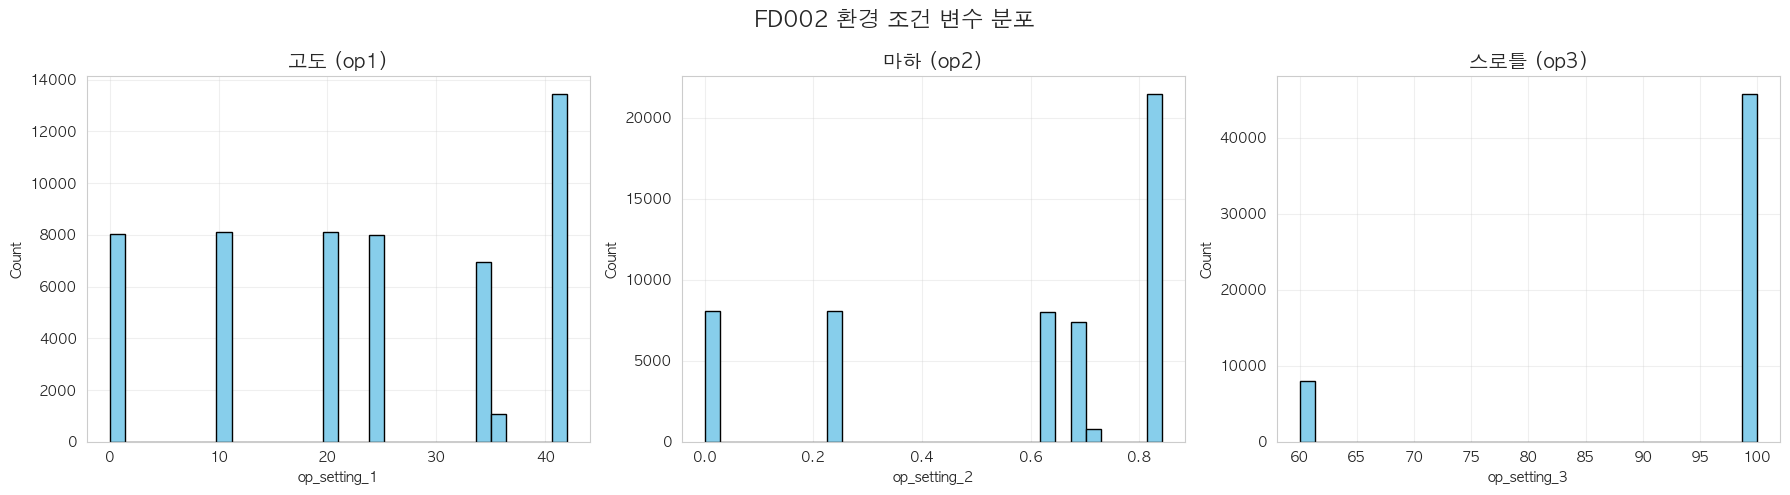

In [48]:
# FD002 환경 조건 변수 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
env_vars = ['op_setting_1', 'op_setting_2', 'op_setting_3']
titles = ['고도 (op1)', '마하 (op2)', '스로틀 (op3)']
for i, var in enumerate(env_vars):
    axes[i].hist(train_df[var], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].grid(alpha=0.3)
plt.suptitle('FD002 환경 조건 변수 분포', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- op1(고도) : 다중 이산 값  
0, 10, 20, 등의 특정 값들로 구성됨.  
연속적인 설정값이 아닌 단계별로 나뉘는 값.  
ex) 10 => 10,000 피트 고도 구간  
---
- op2(마하수) : 다중 이산 값  
0.0, 0.25, 0.6, 0.8 등 특정 값에 데이터가 분포  
연속적인 설정값이 아닌 단계별로 나뉘는 값.  
---
- op3(스로틀) : 이진 값  
60과 100, 단 2가지 추력 조건을 가짐  
이진 값으로 나타나는 특징이 보임.  
---
FD002, FD004는 6가지의 복합 운전 조건이 존재  
NASA 논문에 따르면, 고도, 마하수, 스로틀이 서로 다른 6가지의 조합을 나타냄  

## 3. 전체 사이클 분포 분석

각 엔진의 전체 수명 사이클 수를 파악하고, RUL을 계산합니다.

In [49]:
# 각 엔진별 전체 사이클 수 계산
train_max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
train_max_cycles.columns = ['unit_id', 'max_cycles']

print("엔진별 전체 사이클 수 통계:")
print(train_max_cycles['max_cycles'].describe())
print(f"\n총 엔진 수: {train_max_cycles['unit_id'].nunique()}개")
print(f"평균 수명: {train_max_cycles['max_cycles'].mean():.2f} cycles")
print(f"최소 수명: {train_max_cycles['max_cycles'].min()} cycles")
print(f"최대 수명: {train_max_cycles['max_cycles'].max()} cycles")

엔진별 전체 사이클 수 통계:
count    260.000000
mean     206.765385
std       46.782198
min      128.000000
25%      174.000000
50%      199.000000
75%      230.250000
max      378.000000
Name: max_cycles, dtype: float64

총 엔진 수: 260개
평균 수명: 206.77 cycles
최소 수명: 128 cycles
최대 수명: 378 cycles


<FD002_unit1>

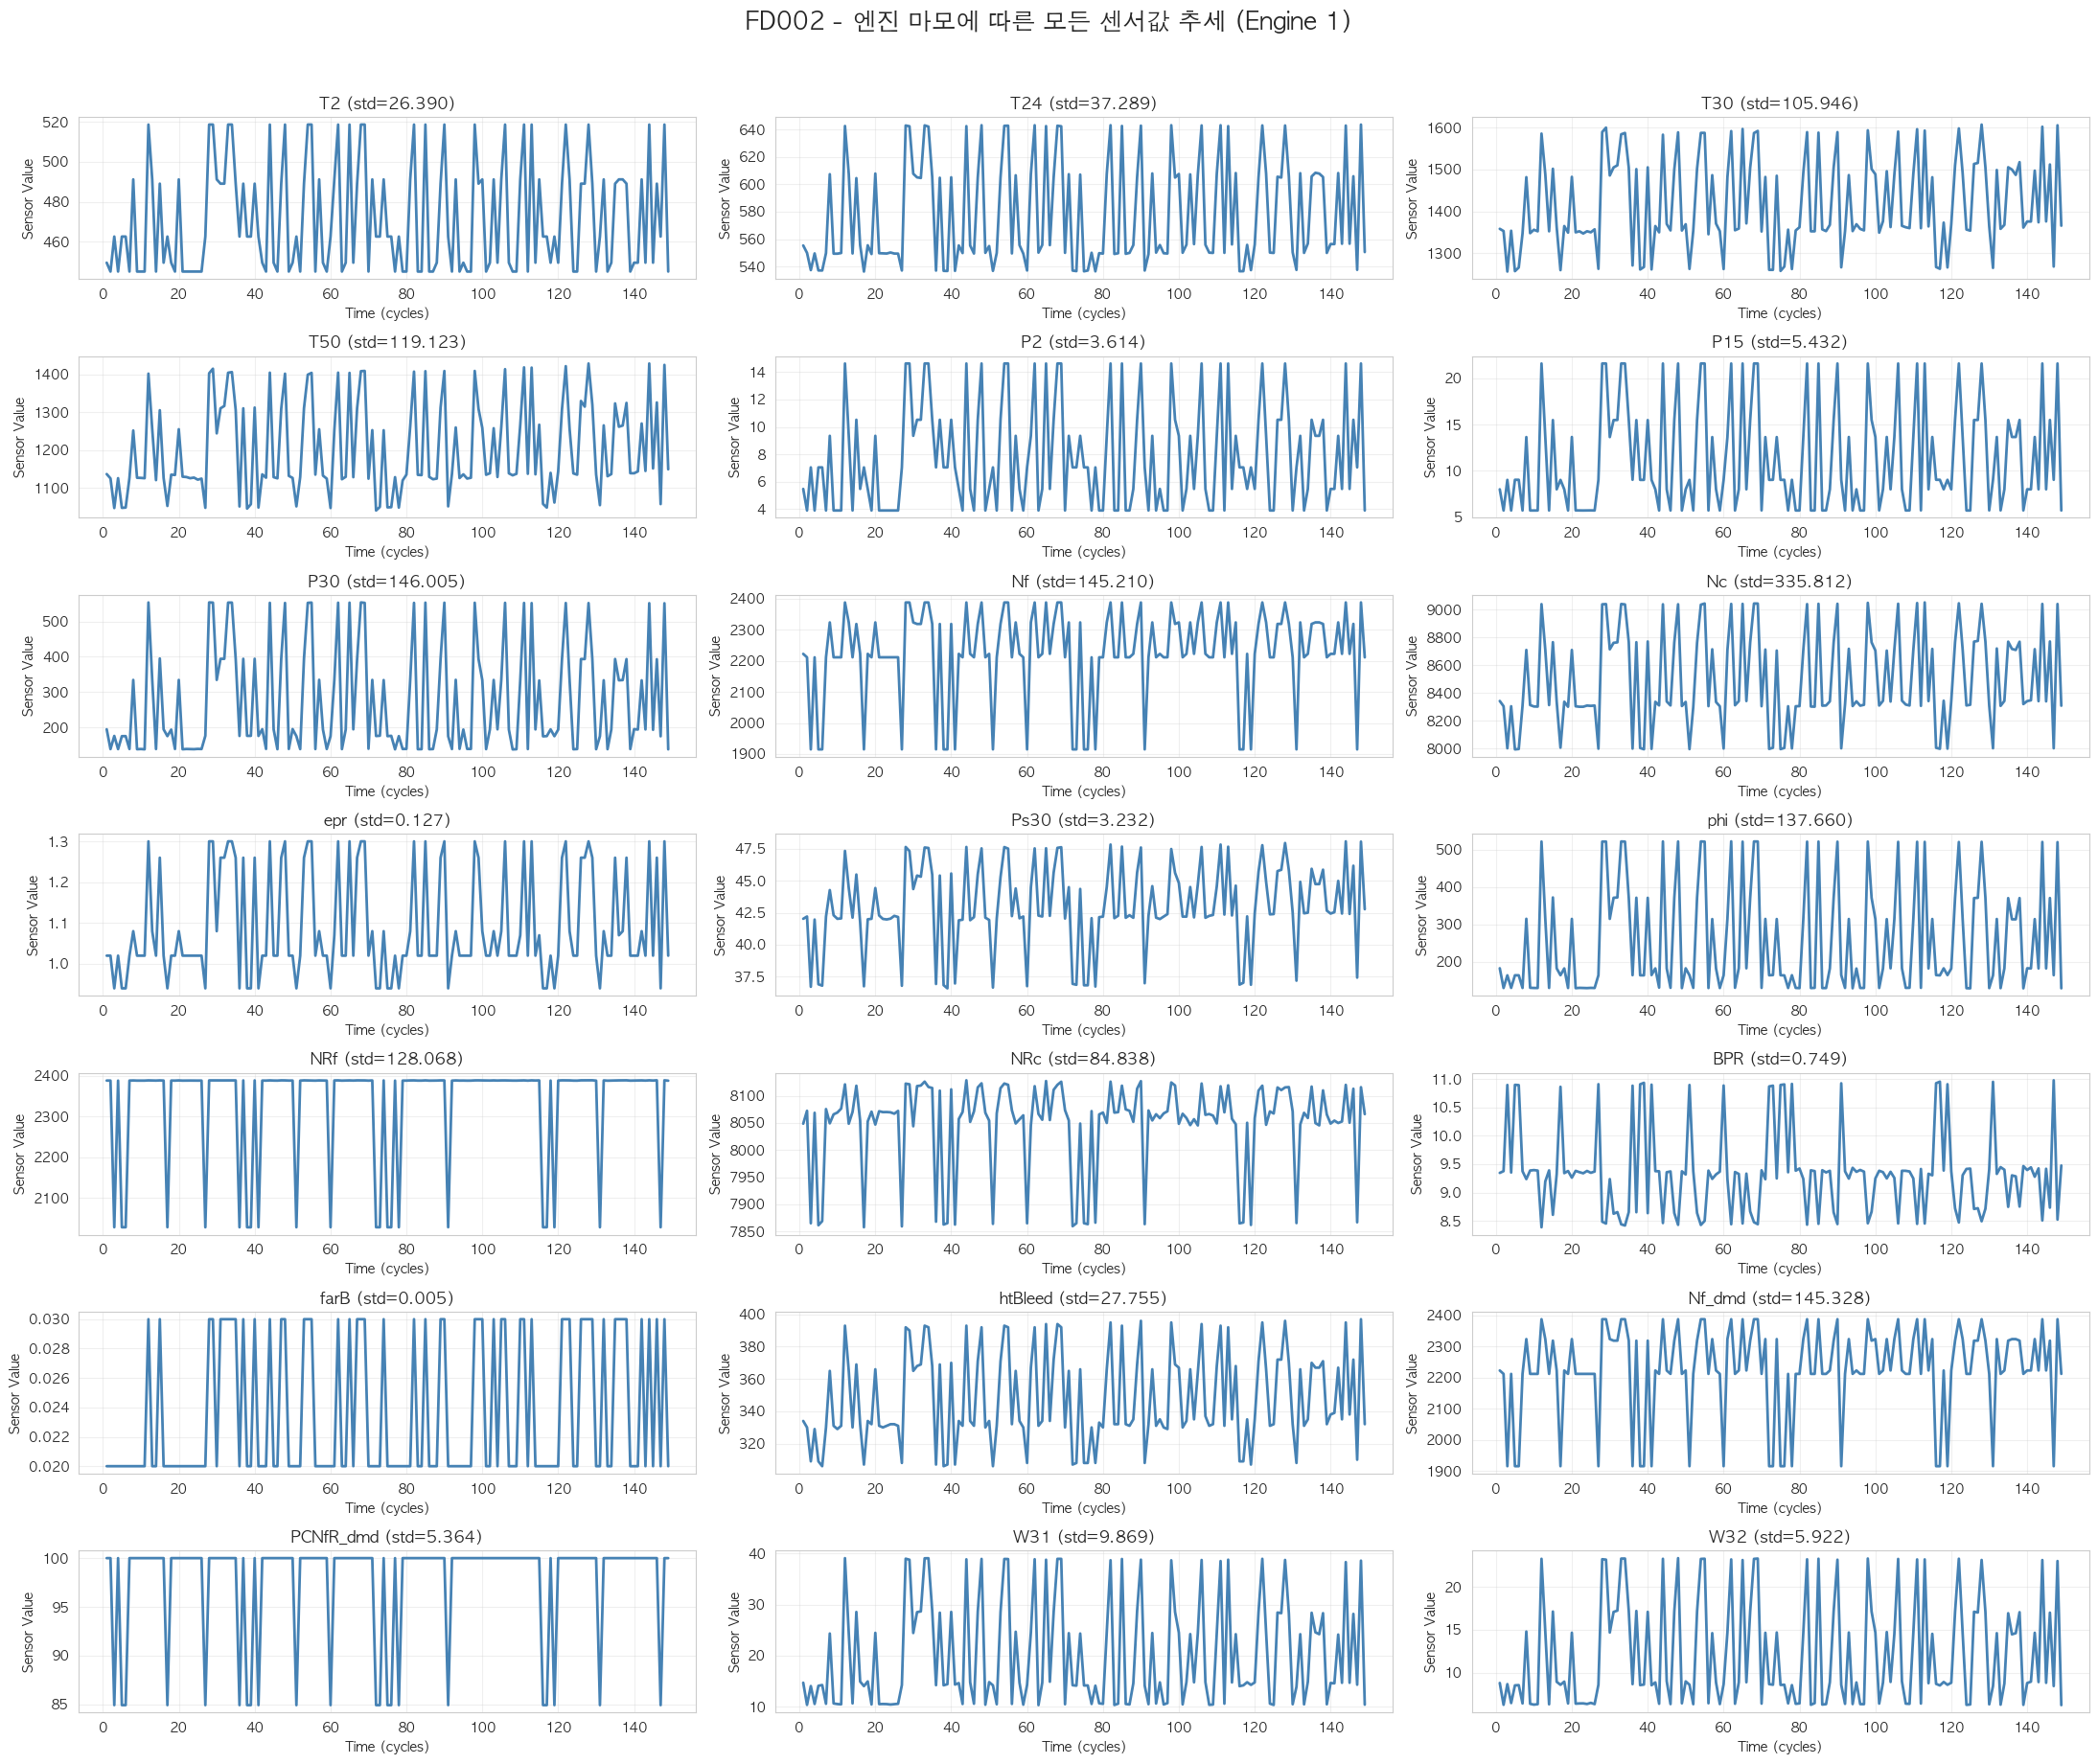

In [65]:
# 엔진 마모(사이클 진행)에 따른 모든 센서값 추세 시각화 (Engine 1, 21개 센서)
sample_engine = train_df[train_df['unit_id'] == 1].copy()
all_sensors = sensor_cols  # 21개 센서 모두
fig, axes = plt.subplots(7, 3, figsize=(22, 18))
axes = axes.ravel()
for idx, sensor in enumerate(all_sensors):
    axes[idx].plot(sample_engine['time_cycles'], sample_engine[sensor], color='steelblue', linewidth=2)
    axes[idx].set_title(f'{sensor} (std={sensor_stats.loc[sensor, "std"]:.3f})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (cycles)', fontsize=10)
    axes[idx].set_ylabel('Sensor Value', fontsize=10)
    axes[idx].grid(alpha=0.3)
# 빈 서브플롯 숨기기 (21개 이후)
for idx in range(len(all_sensors), len(axes)):
    axes[idx].axis('off')
plt.suptitle('FD002 - 엔진 마모에 따른 모든 센서값 추세 (Engine 1)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

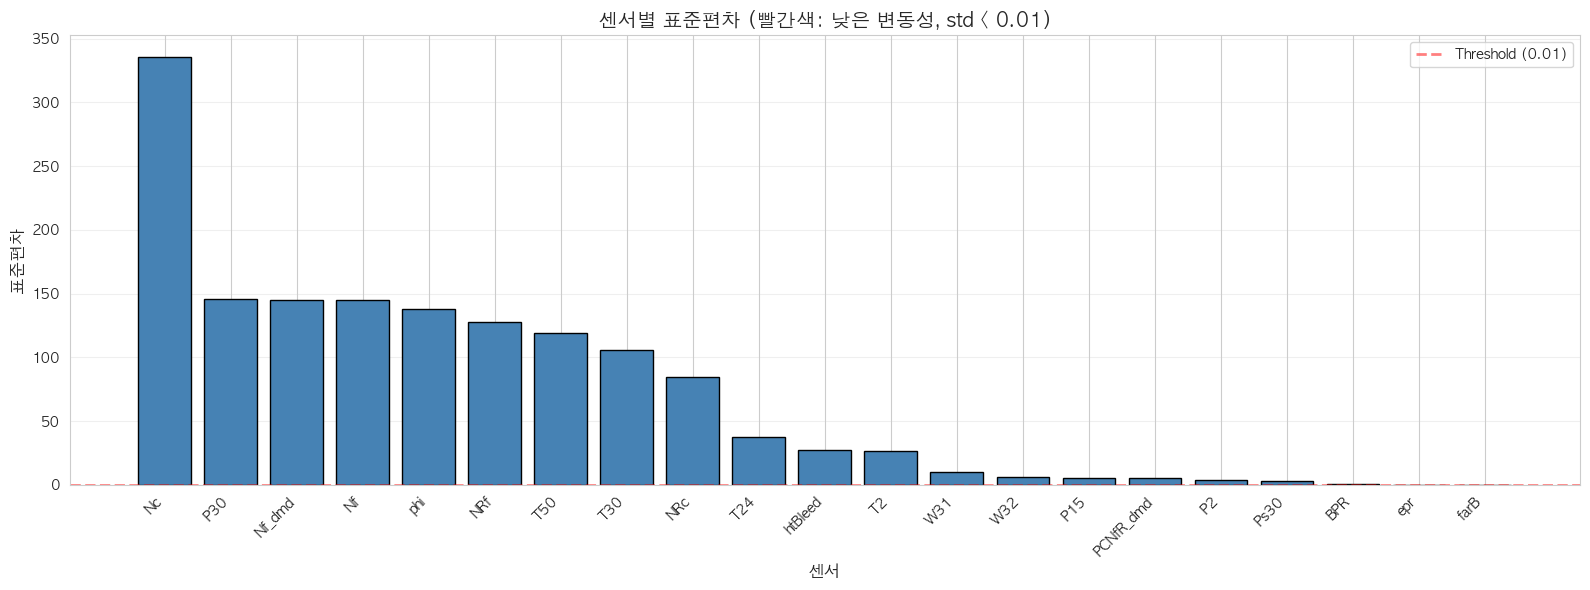

In [66]:
# 센서별 표준편차 시각화
fig, ax = plt.subplots(figsize=(16, 6))

sensor_stats_sorted = sensor_stats.sort_values('std', ascending=False)
colors = ['red' if x < 0.01 else 'steelblue' for x in sensor_stats_sorted['std']]

ax.bar(range(len(sensor_stats_sorted)), sensor_stats_sorted['std'], color=colors, edgecolor='black')
ax.set_xticks(range(len(sensor_stats_sorted)))
ax.set_xticklabels(sensor_stats_sorted.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('표준편차', fontsize=12)
ax.set_title('센서별 표준편차 (빨간색: 낮은 변동성, std < 0.01)', fontsize=14, fontweight='bold')
ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.01)')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Nc(코어 속도) 높은 편차를 보임.  
그 외 변수들 또한 운전 조건 변화에 의하여 편차가 발생.  

In [52]:
# RUL(Remaining Useful Life) 계산 함수
def add_rul(df):
    df = df.copy()
    # 각 엔진별 최대 사이클 계산
    max_cycles = df.groupby('unit_id')['time_cycles'].max().reset_index()
    max_cycles.columns = ['unit_id', 'max_cycles']
    
    # 원본 데이터와 병합
    df = df.merge(max_cycles, on='unit_id', how='left')
    
    # RUL 계산: 전체 수명 - 현재 사이클
    df['RUL'] = df['max_cycles'] - df['time_cycles']
    
    # max_cycles 컬럼 제거
    df = df.drop('max_cycles', axis=1)
    
    return df

# Train 데이터에 RUL 추가
train_df = add_rul(train_df)

print("RUL 추가 완료!")
print(f"\nTrain 데이터 shape: {train_df.shape}")
print(f"\nRUL 통계:")
print(train_df['RUL'].describe())

RUL 추가 완료!

Train 데이터 shape: (53759, 27)

RUL 통계:
count    53759.000000
mean       108.154746
std         69.180569
min          0.000000
25%         51.000000
50%        103.000000
75%        156.000000
max        377.000000
Name: RUL, dtype: float64


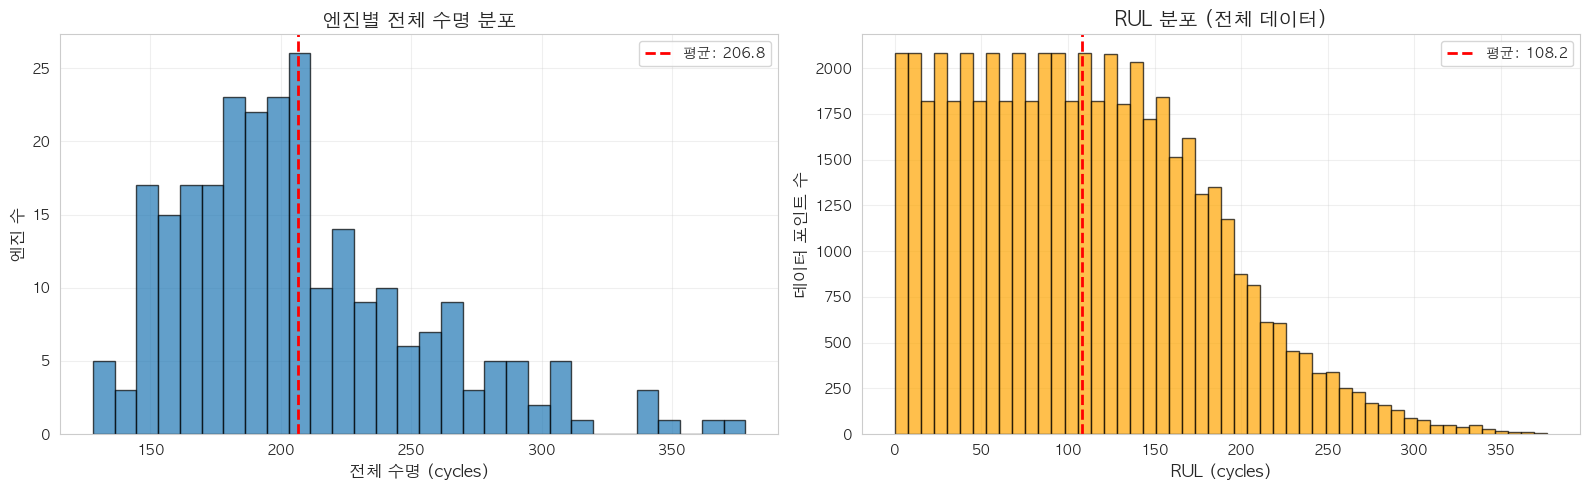

In [53]:
# 사이클 수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. 엔진별 전체 사이클 수 히스토그램
axes[0].hist(train_max_cycles['max_cycles'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(train_max_cycles['max_cycles'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_max_cycles['max_cycles'].mean():.1f}")
axes[0].set_xlabel('전체 수명 (cycles)', fontsize=12)
axes[0].set_ylabel('엔진 수', fontsize=12)
axes[0].set_title('엔진별 전체 수명 분포', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. RUL 분포
axes[1].hist(train_df['RUL'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(train_df['RUL'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_df['RUL'].mean():.1f}")
axes[1].set_xlabel('RUL (cycles)', fontsize=12)
axes[1].set_ylabel('데이터 포인트 수', fontsize=12)
axes[1].set_title('RUL 분포 (전체 데이터)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

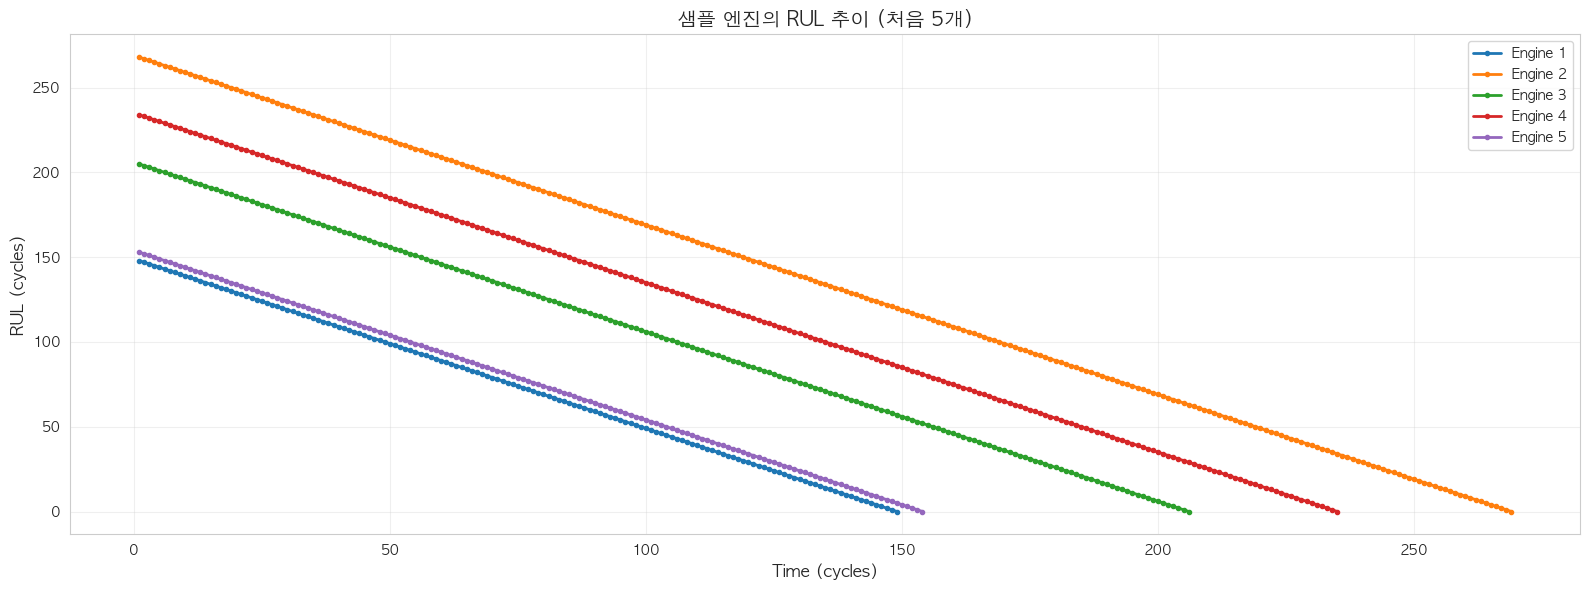

In [54]:
# 샘플 엔진의 수명 곡선 시각화 (처음 5개 엔진)
fig, ax = plt.subplots(figsize=(16, 6))

sample_units = train_df['unit_id'].unique()[:5]
for unit in sample_units:
    unit_data = train_df[train_df['unit_id'] == unit]
    ax.plot(unit_data['time_cycles'], unit_data['RUL'], 
            marker='o', markersize=3, label=f'Engine {unit}', linewidth=2)

ax.set_xlabel('Time (cycles)', fontsize=12)
ax.set_ylabel('RUL (cycles)', fontsize=12)
ax.set_title('샘플 엔진의 RUL 추이 (처음 5개)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. 센서별 드리프트/패턴 분석

21개 센서 데이터의 특성을 분석합니다:
- 시간에 따른 변화 패턴
- 분산 및 변동성
- RUL과의 상관관계

In [55]:
# 센서 데이터 분산 분석
sensor_stats = pd.DataFrame()
sensor_stats['std'] = train_df[sensor_cols].std()
sensor_stats['variance'] = train_df[sensor_cols].var()
sensor_stats['mean'] = train_df[sensor_cols].mean()
sensor_stats['min'] = train_df[sensor_cols].min()
sensor_stats['max'] = train_df[sensor_cols].max()
sensor_stats['range'] = sensor_stats['max'] - sensor_stats['min']

# 변동성이 거의 없는 센서 식별 (표준편차 < 0.01)
low_variance_sensors = sensor_stats[sensor_stats['std'] < 0.01].index.tolist()

print("센서별 통계:")
print(sensor_stats.sort_values('std', ascending=False))


센서별 통계:
                  std       variance         mean        min        max  \
Nc         335.812013  112769.707858  8525.200837  7985.5600  9215.6600   
P30        146.005306   21317.549421   282.606787   136.8000   555.8200   
Nf_dmd     145.327980   21120.221812  2228.806358  1915.0000  2388.0000   
Nf         145.209816   21085.890683  2228.879188  1914.7700  2388.3900   
phi        137.659507   18950.139854   266.069034   129.1200   523.3700   
NRf        128.068271   16401.482048  2334.557253  2027.6100  2390.4800   
T50        119.123428   14190.391000  1205.442024  1023.7700  1439.2300   
T30        105.946341   11224.627089  1419.971013  1243.7300  1612.8800   
NRc         84.837950    7197.477708  8066.597682  7848.3600  8268.5000   
T24         37.289399    1390.499279   579.672399   535.5300   644.5200   
htBleed     27.754515     770.313126   348.309511   303.0000   399.0000   
T2          26.389707     696.416652   472.910207   445.0000   518.6700   
W31          9.86

In [56]:
print(f"\n낮은 변동성 센서 (std < 0.01): {low_variance_sensors}")


낮은 변동성 센서 (std < 0.01): ['farB']


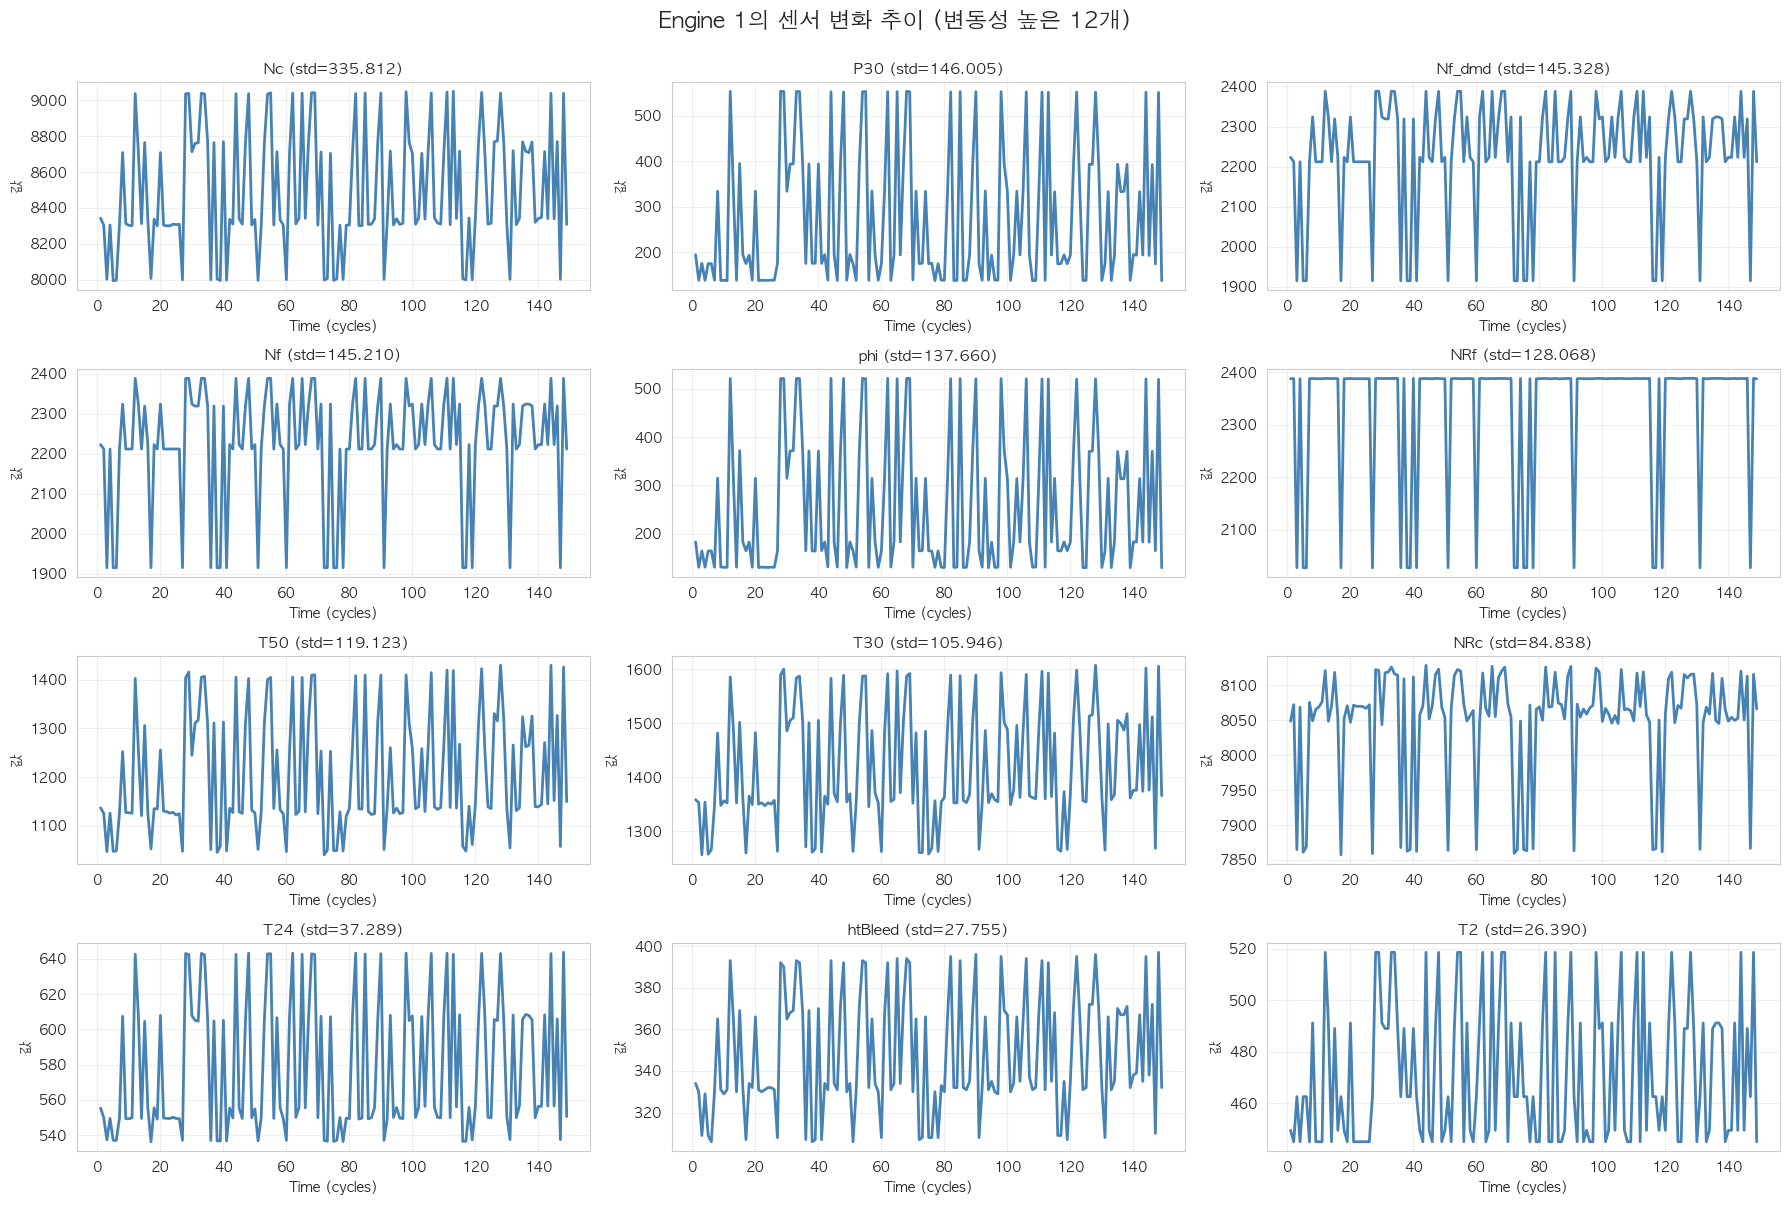

In [58]:
# 샘플 엔진(unit_id=1)의 센서 추이 시각화
sample_engine = train_df[train_df['unit_id'] == 1].copy()

# 변동성이 높은 상위 12개 센서 선택
top_sensors = sensor_stats.nlargest(12, 'std').index.tolist()

fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, sensor in enumerate(top_sensors):
    axes[idx].plot(sample_engine['time_cycles'], sample_engine[sensor], 
                   linewidth=2, color='steelblue')
    axes[idx].set_xlabel('Time (cycles)', fontsize=10)
    axes[idx].set_ylabel('값', fontsize=10)
    axes[idx].set_title(f'{sensor} (std={sensor_stats.loc[sensor, "std"]:.3f})', 
                        fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Engine 1의 센서 변화 추이 (변동성 높은 12개)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

RUL과의 상관계수 (절대값 기준 상위 10개):
farB       0.071352
Ps30       0.046950
NRc        0.042325
T50        0.040978
BPR        0.038455
htBleed    0.027031
T30        0.026942
Nc         0.015306
W31        0.006287
W32        0.006165
Name: RUL, dtype: float64


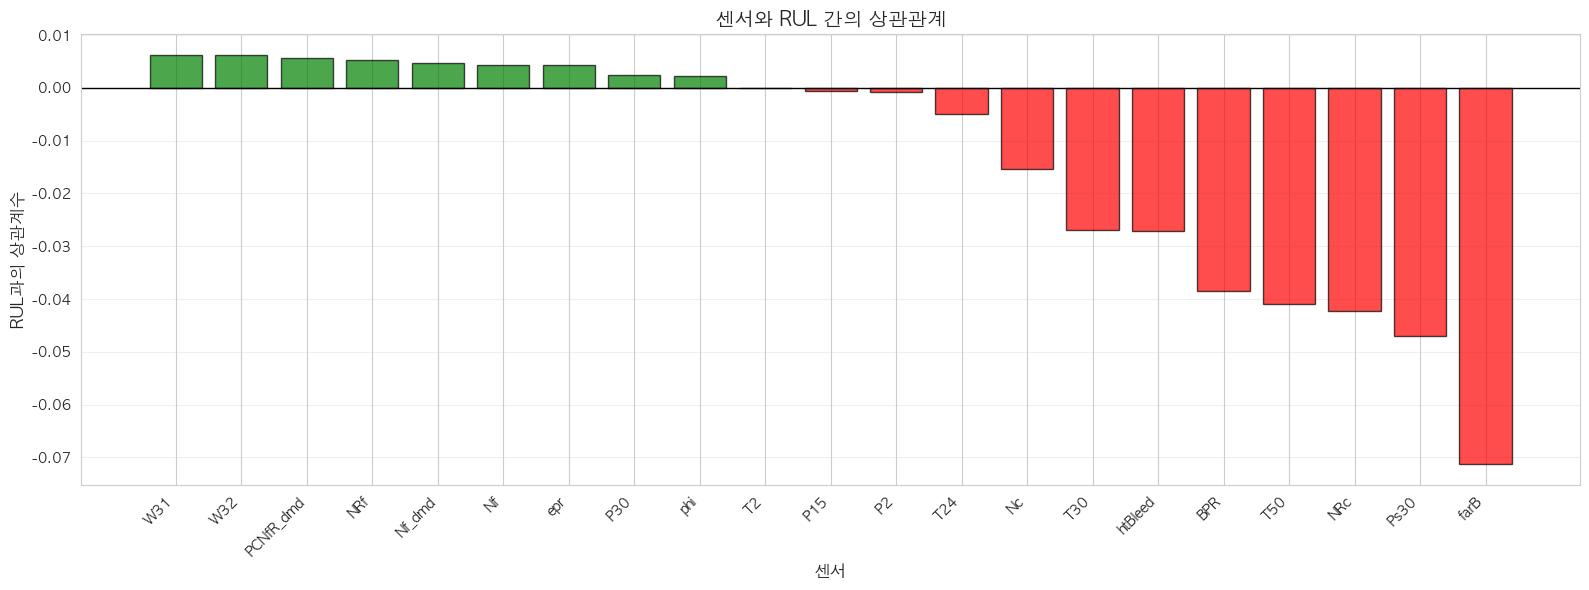

In [59]:
# RUL과 센서 간의 상관관계 분석
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

print("RUL과의 상관계수 (절대값 기준 상위 10개):")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

# 상관계수 시각화
fig, ax = plt.subplots(figsize=(16, 6))

colors = ['green' if x > 0 else 'red' for x in correlation_with_rul.values]
ax.bar(range(len(correlation_with_rul)), correlation_with_rul.values, 
       color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(correlation_with_rul)))
ax.set_xticklabels(correlation_with_rul.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('RUL과의 상관계수', fontsize=12)
ax.set_title('센서와 RUL 간의 상관관계', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. 제거할 센서 리스트 확정

제거 기준:
1. **낮은 변동성**: 표준편차 < 0.01 (거의 상수값)
2. **낮은 상관성**: |상관계수| < 0.1 (RUL과의 관계가 약함)

In [60]:
# 제거할 센서 식별
std_threshold = 0.01
corr_threshold = 0.03

# 1. 낮은 변동성 센서
low_variance = sensor_stats[sensor_stats['std'] < std_threshold].index.tolist()

# 2. 낮은 상관성 센서
low_correlation = correlation_with_rul[abs(correlation_with_rul) < corr_threshold].index.tolist()

# 합집합 (둘 중 하나라도 해당되면 제거 후보)
sensors_to_remove = list(set(low_variance + low_correlation))
sensors_to_remove.sort()

# 유지할 센서
sensors_to_keep = [s for s in sensor_cols if s not in sensors_to_remove]

print("=" * 60)
print("센서 제거 분석 결과")
print("=" * 60)
print(f"\n1. 낮은 변동성 센서 (std < {std_threshold}):")
print(f"   {low_variance}")
print(f"\n2. 낮은 상관성 센서 (|corr| < {corr_threshold}):")
print(f"   {low_correlation}")
print(f"\n제거할 센서 (총 {len(sensors_to_remove)}개):")
print(f"   {sensors_to_remove}")
print(f"\n유지할 센서 (총 {len(sensors_to_keep)}개):")
print(f"   {sensors_to_keep}")

# 제거 상세 정보
print("\n" + "=" * 60)
print("제거 센서 상세 정보")
print("=" * 60)
removal_info = pd.DataFrame({
    'sensor': sensors_to_remove,
    'std': [sensor_stats.loc[s, 'std'] for s in sensors_to_remove],
    'corr_with_RUL': [correlation_with_rul.loc[s] for s in sensors_to_remove],
    'reason': ['Low Variance' if s in low_variance else 'Low Correlation' 
               for s in sensors_to_remove]
})
print(removal_info.to_string(index=False))

센서 제거 분석 결과

1. 낮은 변동성 센서 (std < 0.01):
   ['farB']

2. 낮은 상관성 센서 (|corr| < 0.03):
   ['W31', 'W32', 'PCNfR_dmd', 'NRf', 'Nf_dmd', 'Nf', 'epr', 'P30', 'phi', 'T2', 'P15', 'P2', 'T24', 'Nc', 'T30', 'htBleed']

제거할 센서 (총 17개):
   ['NRf', 'Nc', 'Nf', 'Nf_dmd', 'P15', 'P2', 'P30', 'PCNfR_dmd', 'T2', 'T24', 'T30', 'W31', 'W32', 'epr', 'farB', 'htBleed', 'phi']

유지할 센서 (총 4개):
   ['T50', 'Ps30', 'NRc', 'BPR']

제거 센서 상세 정보
   sensor        std  corr_with_RUL          reason
      NRf 128.068271       0.005245 Low Correlation
       Nc 335.812013      -0.015306 Low Correlation
       Nf 145.209816       0.004345 Low Correlation
   Nf_dmd 145.327980       0.004780 Low Correlation
      P15   5.431802      -0.000496 Low Correlation
       P2   3.613839      -0.000758 Low Correlation
      P30 146.005306       0.002430 Low Correlation
PCNfR_dmd   5.364067       0.005761 Low Correlation
       T2  26.389707      -0.000023 Low Correlation
      T24  37.289399      -0.004928 Low Correlation
      T3

## 6. Rolling Window 길이 확정

시계열 특성을 반영하기 위한 Rolling Window 기법 적용:
- 각 시점의 센서 값을 과거 N개 사이클의 통계로 변환
- 노이즈 감소 및 트렌드 파악에 유용
- Window 크기에 따른 성능 비교 필요

In [61]:
# Rolling Window 테스트 함수
def apply_rolling_window(df, window_size, sensor_list):

    df_rolled = df.copy()
    
    for sensor in sensor_list:
        # Rolling Mean
        df_rolled[f'{sensor}_rolling_mean'] = df_rolled.groupby('unit_id')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).mean()
        )
        # Rolling Std
        df_rolled[f'{sensor}_rolling_std'] = df_rolled.groupby('unit_id')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).std()
        )
    
    return df_rolled

# 테스트: 여러 window 크기 비교
window_sizes = [5, 10, 15, 20, 30]
sample_sensor = sensors_to_keep[0]  # 첫 번째 유효 센서로 테스트

print(f"테스트 센서: {sample_sensor}")
print(f"테스트 윈도우 크기: {window_sizes}")

테스트 센서: T50
테스트 윈도우 크기: [5, 10, 15, 20, 30]


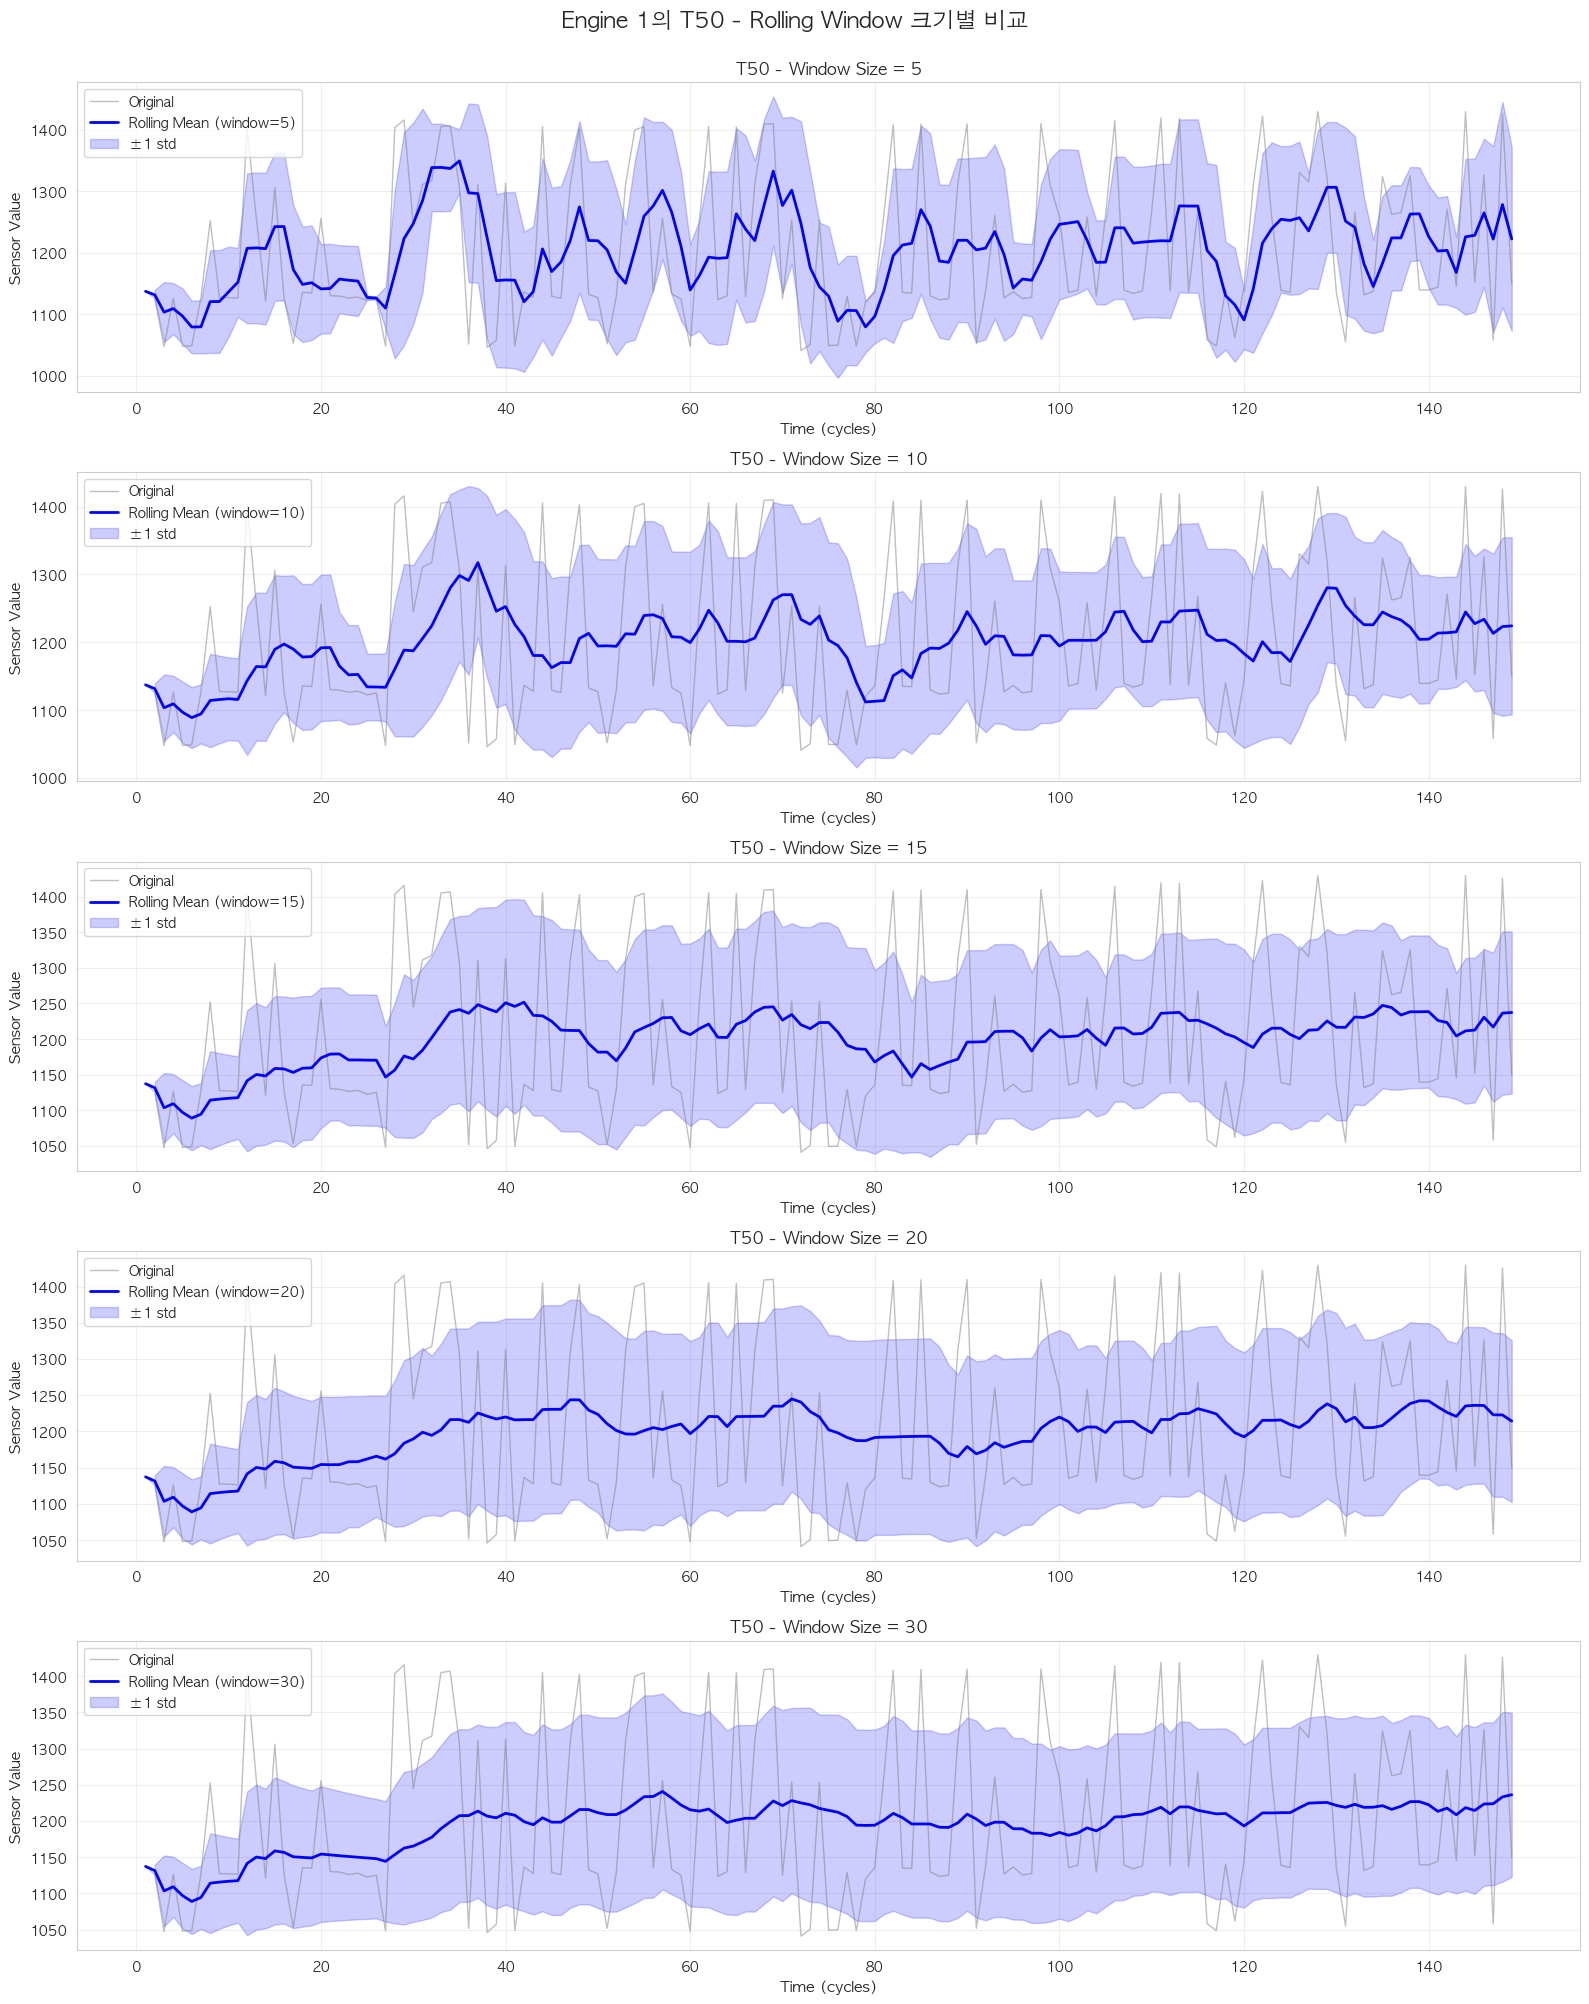

In [62]:
# 샘플 엔진으로 Window 크기별 효과 시각화
sample_unit_data = train_df[train_df['unit_id'] == 1].copy()

fig, axes = plt.subplots(len(window_sizes), 1, figsize=(16, 4*len(window_sizes)))

for idx, window in enumerate(window_sizes):
    # Rolling mean 계산
    rolling_mean = sample_unit_data[sample_sensor].rolling(window=window, min_periods=1).mean()
    rolling_std = sample_unit_data[sample_sensor].rolling(window=window, min_periods=1).std()
    
    # 시각화
    axes[idx].plot(sample_unit_data['time_cycles'], sample_unit_data[sample_sensor], 
                   label='Original', alpha=0.5, linewidth=1, color='gray')
    axes[idx].plot(sample_unit_data['time_cycles'], rolling_mean, 
                   label=f'Rolling Mean (window={window})', linewidth=2, color='blue')
    axes[idx].fill_between(sample_unit_data['time_cycles'], 
                           rolling_mean - rolling_std, 
                           rolling_mean + rolling_std, 
                           alpha=0.2, color='blue', label='±1 std')
    
    axes[idx].set_xlabel('Time (cycles)', fontsize=11)
    axes[idx].set_ylabel('Sensor Value', fontsize=11)
    axes[idx].set_title(f'{sample_sensor} - Window Size = {window}', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'Engine 1의 {sample_sensor} - Rolling Window 크기별 비교', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [63]:
# Window 크기별 데이터 손실률 분석
print("=" * 60)
print("Rolling Window 크기별 분석")
print("=" * 60)

for window in window_sizes:
    # 각 엔진에서 window 크기보다 작은 데이터 포인트 비율
    total_points = len(train_df)
    lost_info_points = len(train_df[train_df.groupby('unit_id')['time_cycles'].transform('count') < window])
    
    # 평균 사이클 대비 비율
    avg_cycles = train_max_cycles['max_cycles'].mean()
    window_pct = (window / avg_cycles) * 100
    
    print(f"\nWindow Size: {window}")
    print(f"  - 평균 수명 대비 비율: {window_pct:.2f}%")
    print(f"  - 초기 {window} 사이클의 정보 손실: {window} cycles")
    print(f"  - 전체 데이터 중 완전한 통계 불가 비율: {(lost_info_points/total_points)*100:.2f}%")



Rolling Window 크기별 분석

Window Size: 5
  - 평균 수명 대비 비율: 2.42%
  - 초기 5 사이클의 정보 손실: 5 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 10
  - 평균 수명 대비 비율: 4.84%
  - 초기 10 사이클의 정보 손실: 10 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 15
  - 평균 수명 대비 비율: 7.25%
  - 초기 15 사이클의 정보 손실: 15 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 20
  - 평균 수명 대비 비율: 9.67%
  - 초기 20 사이클의 정보 손실: 20 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 30
  - 평균 수명 대비 비율: 14.51%
  - 초기 30 사이클의 정보 손실: 30 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%


# 전처리 실험 및 효과 비교
이 섹션에서는 FD002 데이터셋에 대해 RUL Clipping, Scaling, Filtering, Feature Engineering 등 주요 전처리 기법을 적용하고, 각 기법의 효과를 분포/시각화/성능 변화로 비교합니다.

## 1. RUL Clipping 실험
- 다양한 threshold(50, 75, 100, 125, 150)로 RUL을 클리핑하여 라벨 분포 안정화 효과를 확인합니다.
- 클리핑 전후 RUL 분포, 표준편차 변화, 모델 성능(RMSE, MAE) 변화를 시각화합니다.

## 2. Scaling(스케일링) 실험
- Standard, MinMax, Robust Scaler를 적용하여 센서 분포 및 모델 성능 변화를 비교합니다.
- 운전 조건별 스케일링 민감도도 함께 분석합니다.

## 3. Filtering(필터링) 실험
- moving_avg, savgol, butterworth, median, gaussian 등 5개 필터를 적용하여 센서 신호의 노이즈 감소 및 곡률 지연 trade-off를 분석합니다.
- 필터별 주요 센서 신호 변화와 모델 성능을 비교합니다.

## 4. Feature Engineering(피처 엔지니어링) 실험
- rolling stats, derivative, sensor selection 등 피처 엔지니어링 기법을 적용하여 성능 변화를 분석합니다.
- 운전 조건별 효과 차이도 함께 시각화합니다.

---
각 실험별로 코드/시각화/해석 셀을 추가하여 포트폴리오 완성도를 높일 수 있습니다.